# ML DEFRA Data Preparation - 6 REGULATORY POLLUTANTS

**Extended version:** Processes 6 regulatory pollutants (NO2, PM2.5, PM10, O3, SO2, CO) across all DEFRA stations for comprehensive model training. Mirrors LAQN ml_prep_all structure for fair comparison.

## What this notebook does

1. Loads cleaned data from the optimised folder.

   ```bash
   ├── optimised/
   │   ├── 2023measurements/
   │   │   ├── Station_Name/
   │   │   │   ├── NO2__2023_01.csv
   │   │   │   ├── PM10__2023_01.csv
   │   │   │   └── ...
   │   ├── 2024measurements/
   │   └── 2025measurements/
   ```

2. Filters to 6 regulatory pollutants matching LAQN.
3. Combines all measurements into a single dataset.
4. Creates temporal features (hour, day, month).
5. Creates sequences for ML training.

## Why 6 pollutants?

For direct comparison with LAQN, we need identical pollutant sets. LAQN monitors these 6 regulatory pollutants, so DEFRA needs to match.

## Output path:

Data will be saved to: `data/defra/ml_prep_all/`

- Usual drill, I will be adding my paths under this md cell for organise myself better.

In [2]:
# starting with adding mandotary and very helpful python modules below.
import pandas as pd
import numpy as np
import os
from pathlib import Path

#save 12 section
import joblib

#visilisation section 13
import matplotlib.pyplot as plt

# preprocessing libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

- The dataset/file paths will be below.

In [3]:
# DEFRA prep file paths
base_dir = Path.cwd().parent.parent / "data" / "defra"
project_root = Path.cwd() / "ml_prep_defra_all.ipynb"

# DEFRA optimised data path
optimised_path = base_dir / "optimised"

# Output path - 6 pollutant version to match LAQN
output_path = base_dir / "ml_prep_all"
output_path.mkdir(parents=True, exist_ok=True)

# Visualisation output path
visualisation_path = output_path / "visualisation"
visualisation_path.mkdir(parents=True, exist_ok=True)

print(f"Base directory: {base_dir}")
print(f"Data path: {optimised_path}")
print(f"Output path: {output_path}")
print(f"Path exists: {optimised_path.exists()}")

Base directory: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra
Data path: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra/optimised
Output path: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra/ml_prep_all
Path exists: True


In [4]:
# Define constants at top of notebook
n_past = 12
n_future = 1

## 1) Load DEFRA data

DEFRA structure is nested: `optimised/YEARmeasurements/Station_Name/Pollutant__YYYY_MM.csv`

CSV columns: `timestamp, value, timeseries_id, station_name, pollutant_name, pollutant_std, latitude, longitude`

We'll map these to match LAQN column names for consistency:
- `timestamp` → `@MeasurementDateGMT`
- `value` → `@Value`
- `pollutant_std` → `SpeciesCode`
- `station_name` → `SiteCode` (with spaces replaced)

In [5]:
def load_defra_data(optimised_path):
    """
    Function to load the optimised data files from the defra dataset.
    
    Param:
        optimised_path: path for data/defra/optimised directory.
    """
    optimised_path = Path(optimised_path)
    all_files = []
    file_count = 0
    
    # Get year measurement folders (2023measurements, 2024measurements, etc.)
    year_folders = sorted([f for f in optimised_path.iterdir() 
                          if f.is_dir() and 'measurements' in f.name])
    
    print(f"Found {len(year_folders)} year folders")
    
    for year_dir in year_folders:
        year_file_count = 0
        
        # Get station folders inside each year
        station_folders = sorted([f for f in year_dir.iterdir() if f.is_dir()])
        
        for station_dir in station_folders:
            # Get all CSV files in station folder
            for csv_file in station_dir.glob("*.csv"):
                try:
                    df = pd.read_csv(csv_file)
                    all_files.append(df)
                    file_count += 1
                    year_file_count += 1
                except Exception as e:
                    print(f"Error reading {csv_file.name}: {e}")
        
        print(f"  Loaded {year_dir.name}: {year_file_count} files")
    
    # Combine all dataframes
    if not all_files:
        raise ValueError(f"No CSV files found in {optimised_path}")
    
    combined_df = pd.concat(all_files, ignore_index=True)
    
    print(f"\n" + "="*40)
    print(f"Total files loaded: {file_count}")
    print(f"Total rows: {len(combined_df):,}")
    print(f"Columns: {list(combined_df.columns)}")
    
    return combined_df

In [6]:
# Load all DEFRA data
df_raw = load_defra_data(optimised_path)
df_raw.head()

Found 3 year folders
  Loaded 2023measurements: 1431 files
  Loaded 2024measurements: 1193 files
  Loaded 2025measurements: 939 files

Total files loaded: 3563
Total rows: 2,525,991
Columns: ['timestamp', 'value', 'timeseries_id', 'station_name', 'pollutant_name', 'pollutant_std', 'latitude', 'longitude']


,timestamp,value,timeseries_id,station_name,pollutant_name,pollutant_std,latitude,longitude
0,2023-09-01 00:00:00,26.966,4566,Borehamwood Meadow Park,Nitrogen oxides,NOx,51.661229,-0.27055
1,2023-09-01 01:00:00,27.349,4566,Borehamwood Meadow Park,Nitrogen oxides,NOx,51.661229,-0.27055
2,2023-09-01 02:00:00,22.567,4566,Borehamwood Meadow Park,Nitrogen oxides,NOx,51.661229,-0.27055
3,2023-09-01 04:00:00,17.021,4566,Borehamwood Meadow Park,Nitrogen oxides,NOx,51.661229,-0.27055
4,2023-09-01 05:00:00,23.141,4566,Borehamwood Meadow Park,Nitrogen oxides,NOx,51.661229,-0.27055


## 2) Rename columns to match LAQN format

Mapping DEFRA columns to LAQN equivalent names so both datasets have identical structure for model comparison.

In [7]:
# Rename columns to match LAQN format
df_raw = df_raw.rename(columns={
    'timestamp': '@MeasurementDateGMT',
    'value': '@Value',
    'pollutant_std': 'SpeciesCode',
    'station_name': 'SiteName'
})

# Create SiteCode from SiteName (replace spaces with underscores)
df_raw['SiteCode'] = df_raw['SiteName'].str.replace(' ', '_')

print(f"Renamed columns: {df_raw.columns.tolist()}")
df_raw.head()

Renamed columns: ['@MeasurementDateGMT', '@Value', 'timeseries_id', 'SiteName', 'pollutant_name', 'SpeciesCode', 'latitude', 'longitude', 'SiteCode']


,@MeasurementDateGMT,@Value,timeseries_id,SiteName,pollutant_name,SpeciesCode,latitude,longitude,SiteCode
0,2023-09-01 00:00:00,26.966,4566,Borehamwood Meadow Park,Nitrogen oxides,NOx,51.661229,-0.27055,Borehamwood_Meadow_Park
1,2023-09-01 01:00:00,27.349,4566,Borehamwood Meadow Park,Nitrogen oxides,NOx,51.661229,-0.27055,Borehamwood_Meadow_Park
2,2023-09-01 02:00:00,22.567,4566,Borehamwood Meadow Park,Nitrogen oxides,NOx,51.661229,-0.27055,Borehamwood_Meadow_Park
3,2023-09-01 04:00:00,17.021,4566,Borehamwood Meadow Park,Nitrogen oxides,NOx,51.661229,-0.27055,Borehamwood_Meadow_Park
4,2023-09-01 05:00:00,23.141,4566,Borehamwood Meadow Park,Nitrogen oxides,NOx,51.661229,-0.27055,Borehamwood_Meadow_Park


## 3) Handle DEFRA Missing Value Flags

From the DEFRA data quality report:
- DEFRA uses `-99` for maintenance/calibration
- DEFRA uses `-1` for invalid data
- Also has some negative values near detection limits

Replace these with NaN for consistent handling.

In [8]:
def handle_flags(df, value_col='@Value'):
    """
    Replace DEFRA quality flags with NaN.
    
    -99: Station maintenance or calibration
    -1: Other invalid data or insufficient capture
    Negative values: Near detection limit (replace with nan)
    """
    df = df.copy()
    
    # Count flags before replacement
    flag_99 = (df[value_col] == -99).sum()
    flag_1 = (df[value_col] == -1).sum()
    negative = (df[value_col] < 0).sum()
    
    print(f"DEFRA quality flags found:")
    print(f"  -99 (maintenance): {flag_99:,} ({flag_99/len(df)*100:.2f}%)")
    print(f"  -1 (invalid): {flag_1:,} ({flag_1/len(df)*100:.2f}%)")
    print(f"  All negative values: {negative:,} ({negative/len(df)*100:.2f}%)")
    
    # Replace -99 and -1 flags with nan
    df[value_col] = df[value_col].replace([-99, -1], np.nan)
    
    # Replace remaining negative values with NaN (near detection limit)
    df.loc[df[value_col] < 0, value_col] = np.nan
    
    remaining_neg = (df[value_col] < 0).sum()
    print(f"\nAfter cleaning: {remaining_neg} negative values remain.")
    
    return df

# Apply flag handling
df_raw = handle_flags(df_raw)

DEFRA quality flags found:
  -99 (maintenance): 0 (0.00%)
  -1 (invalid): 0 (0.00%)
  All negative values: 0 (0.00%)

After cleaning: 0 negative values remain.


## 4) Data exploration

Already checked data many times but I think it is beneficial to add it here again:

- How many unique stations?
- Which pollutants (species)?
- Date range?
- Total measurements?

In [9]:
# Define column names based on optimised data structure
date_col = '@MeasurementDateGMT'
value_col = '@Value'
site_col = 'SiteCode'
species_col = 'SpeciesCode'

# Convert datetime
df_raw[date_col] = pd.to_datetime(df_raw[date_col])

# run them.
print(f"Unique sites: {df_raw[site_col].nunique()}")
print(f"Unique species: {df_raw[species_col].nunique()}")
print(f"\nDate range: {df_raw[date_col].min()} to {df_raw[date_col].max()}")
print(f"\nSpecies in data:")
print(df_raw[species_col].value_counts())

Unique sites: 18
Unique species: 37

Date range: 2023-01-01 01:00:00 to 2025-11-09 23:00:00

Species in data:
SpeciesCode
NO2                326072
NO                 326061
NOx                325387
PM2.5              234748
PM10               227142
O3                 194333
SO2                 72928
CO                  48578
1,3,5-TMB           26649
i-Octane            26649
Benzene             26649
1,2,3-TMB           26649
Ethylbenzene        26649
Toluene             26649
o-Xylene            26649
n-Octane            26649
n-Heptane           26649
1,2,4-TMB           26649
Propane             26618
n-Pentane           26618
i-Pentane           26618
Ethene              26618
Propene             26618
Isoprene            26618
i-Hexane            26599
trans-2-Butene      26599
trans-2-Pentene     26599
n-Butane            26599
1-Butene            26599
i-Butane            26599
Ethane              26599
cis-2-Butene        26599
n-Hexane            26580
1-Pentene           

## 5) Selecting target pollutants - 6 REGULATORY ONLY

To match LAQN for fair comparison, we filter to the same 6 regulatory pollutants:

| Pollutant | Full Name | Relevance |
|-----------|-----------|----------|
| NO2 | Nitrogen Dioxide | Traffic emissions, UK AQS limit |
| PM2.5 | Fine Particulate | Health impacts, WHO guidance |
| PM10 | Coarse Particulate | UK AQS limit |
| O3 | Ozone | Photochemical, UK AQS limit |
| SO2 | Sulphur Dioxide | Industrial, UK AQS limit |
| CO | Carbon Monoxide | Traffic, EU limit |

**Note:** DEFRA has 37 pollutants total (including VOCs), but for LAQN comparison we only use these 6.

In [10]:
# Target pollutants - matching LAQN exactly
target_pollutants = ['NO2', 'PM2.5', 'PM10', 'O3', 'SO2', 'CO']

# Filter data
df_filtered = df_raw[df_raw[species_col].isin(target_pollutants)].copy()

print(f"Rows before filtering: {len(df_raw):,}")
print(f"Rows after filtering: {len(df_filtered):,}")
print(f"Rows removed (VOCs and others): {len(df_raw) - len(df_filtered):,}")
print(f"\nPollutants included:")
print(df_filtered[species_col].value_counts())

# Fix PM2.5 in the filtered data BEFORE wide format (remove dot)
df_filtered['SpeciesCode'] = df_filtered['SpeciesCode'].str.replace('.', '', regex=False)

# Verify
print(f"\nSpecies codes after fix: {df_filtered['SpeciesCode'].unique()}")

Rows before filtering: 2,525,991
Rows after filtering: 1,103,801
Rows removed (VOCs and others): 1,422,190

Pollutants included:
SpeciesCode
NO2      326072
PM2.5    234748
PM10     227142
O3       194333
SO2       72928
CO        48578
Name: count, dtype: int64

Species codes after fix: ['NO2' 'PM25' 'PM10' 'O3' 'SO2' 'CO']


## 6) Wide formatting

For ML, following Gilik et al. (2021) methodology:

| Method      | Input                                    | Output           |
| ----------- | ---------------------------------------- | ---------------- |
| UNI/UNI     | Historical info of target pollutant only | Single pollutant |
| MULTI/UNI   | Historical info of all pollutants        | Single pollutant |
| MULTI/MULTI | Historical info of all pollutants        | All pollutants   |

From page 11922 (Results section):

> "The multivariate model without using meteorological data revealed the best results."

So to create multivariate input I will be formatting pivot to wider, adding each station/species combination to table.

In [11]:
def wide_format(df, datetime_col, site_col, species_col, value_col):
    """
    Pivot data from long to wide format. 
    Each site-species combination becomes a column.
    Each row represents one timestamp.
    
    Params:
        datetime_col, site_col, species_col, value_col 
    """
    df = df.copy()
    
    # Create site_species identifier
    df['site_species'] = df[site_col] + '_' + df[species_col]
    
    # Pivot table
    # If duplicate datetime-site_species combinations exist, take mean
    pivoted = df.pivot_table(
        index=datetime_col,
        columns='site_species',
        values=value_col,
        aggfunc='mean'
    )
    
    # Sort by datetime
    pivoted = pivoted.sort_index()
    
    print(f"Created wide format:")
    print(f"Timestamps: {len(pivoted):,}")
    print(f"Features (site-species): {len(pivoted.columns)}")
    print(f"Date range: {pivoted.index.min()} to {pivoted.index.max()}")
    
    return pivoted

In [12]:
df_wide = wide_format(df_filtered, date_col, site_col, species_col, value_col)
print("\nFirst 10 columns:")
print(list(df_wide.columns)[:10])
df_wide.head()

Created wide format:
Timestamps: 24,355
Features (site-species): 55
Date range: 2023-01-01 01:00:00 to 2025-11-09 23:00:00

First 10 columns:
['Borehamwood_Meadow_Park_NO2', 'Borehamwood_Meadow_Park_PM10', 'Borehamwood_Meadow_Park_PM25', 'Camden_Kerbside_NO2', 'Camden_Kerbside_PM10', 'Camden_Kerbside_PM25', 'Ealing_Horn_Lane_PM10', 'Haringey_Roadside_NO2', 'London_Bexley_NO2', 'London_Bexley_PM10']


site_species,Borehamwood_Meadow_Park_NO2,Borehamwood_Meadow_Park_PM10,Borehamwood_Meadow_Park_PM25,Camden_Kerbside_NO2,Camden_Kerbside_PM10,Camden_Kerbside_PM25,Ealing_Horn_Lane_PM10,Haringey_Roadside_NO2,London_Bexley_NO2,London_Bexley_PM10,...,London_Norbury_Manor_School_PM10,London_Norbury_Manor_School_PM25,London_Teddington_Bushy_Park_PM10,London_Teddington_Bushy_Park_PM25,London_Westminster_NO2,London_Westminster_O3,London_Westminster_PM25,Southwark_A2_Old_Kent_Road_NO2,Southwark_A2_Old_Kent_Road_PM10,Tower_Hamlets_Roadside_NO2
@MeasurementDateGMT,,,,,,,,,,,,,,,,,,,,,
2023-01-01 01:00:00,4.781,8.5,6.038,7.268,22.223,21.0,NaN,12.240,1.530,NaN,...,NaN,NaN,8.550,5.307,8.396,NaN,7.4,5.546,22.223,5.355
2023-01-01 02:00:00,5.164,8.0,5.189,9.563,8.696,3.0,NaN,8.033,2.678,NaN,...,NaN,NaN,11.300,5.873,7.254,NaN,7.4,4.973,10.628,4.781
2023-01-01 03:00:00,2.678,8.8,4.811,5.546,14.493,5.0,NaN,6.311,1.339,NaN,...,NaN,NaN,13.350,6.887,5.865,NaN,6.4,4.399,12.561,6.311
2023-01-01 04:00:00,2.486,11.3,5.849,4.973,17.392,7.0,NaN,5.737,1.339,NaN,...,NaN,NaN,15.725,7.453,4.864,NaN,5.4,3.825,16.425,3.825
2023-01-01 05:00:00,2.869,11.4,6.038,5.164,16.425,7.0,NaN,7.459,1.530,NaN,...,NaN,NaN,17.550,8.326,4.195,NaN,4.4,3.634,20.290,3.442


## 7) Handle Missing Values - Maximum Data Retention

### Strategy: Tiered Imputation (same as LAQN)

| Step | Method | Gap Size | Rationale |
|------|--------|----------|----------|
| 1 | Drop poor columns | >70% missing | Too unreliable |
| 2 | Linear interpolation | up to 6 hours | Air quality is autocorrelated |
| 3 | Forward/backward fill | up to 4 hours | Edge cases |
| 4 | Rolling 2 week median | remaining | Preserves weekly patterns |
| 5 | Column median | final gaps | Last resort |

### Why this approach?

Using identical missing value strategy as LAQN ensures fair comparison. Different imputation methods could introduce different biases.

In [13]:
missing_pct = (df_wide.isnull().sum() / len(df_wide) * 100).sort_values(ascending=False)
print("Missing value percentage by column (top 20):")
print(missing_pct.head(20))
print(f"\nTotal cells: {df_wide.size:,}")
print(f"Missing cells: {df_wide.isnull().sum().sum():,}")
print(f"Missing percentage: {df_wide.isnull().sum().sum() / df_wide.size * 100:.2f}%")

Missing value percentage by column (top 20):
site_species
London_Eltham_PM10                      97.992199
London_Marylebone_Road_PM10             92.925477
London_Marylebone_Road_PM25             92.297270
Southwark_A2_Old_Kent_Road_PM10         91.923630
London_Eltham_PM25                      91.406282
London_N._Kensington_PM10               91.336481
Ealing_Horn_Lane_PM10                   91.258468
London_N._Kensington_PM25               91.209197
London_Bexley_PM25                      90.958735
Camden_Kerbside_PM25                    90.716485
Camden_Kerbside_PM10                    90.704168
London_Eltham_NO2                       85.001026
London_Eltham_O3                        82.328064
London_Norbury_Manor_School_PM25        82.254157
London_Norbury_Manor_School_PM10        82.254157
London_Honor_Oak_Park_O3                60.156025
London_Teddington_Bushy_Park_PM10       43.338124
London_Teddington_Bushy_Park_PM25       42.861835
London_Haringey_Priory_Park_South_O3    33

### Step 1: Drop columns with more than 70% missing

In [14]:
MAX_MISSING = 70
cols_before = len(df_wide.columns)
missing_rates = df_wide.isnull().sum() / len(df_wide) * 100
cols_to_keep = missing_rates[missing_rates <= MAX_MISSING].index.tolist()
cols_dropped = cols_before - len(cols_to_keep)

df_step1 = df_wide[cols_to_keep].copy()

print(f"Step 1: Column filtering (>{MAX_MISSING}% missing)")
print(f"="*50)
print(f"Columns before: {cols_before}")
print(f"Columns after: {len(cols_to_keep)}")
print(f"Columns dropped: {cols_dropped}")

# Show which columns were dropped
if cols_dropped > 0:
    dropped_cols = missing_rates[missing_rates > MAX_MISSING].index.tolist()
    print(f"\nDropped columns:")
    for col in dropped_cols:
        print(f"  {col}: {missing_rates[col]:.1f}% missing")

Step 1: Column filtering (>70% missing)
Columns before: 55
Columns after: 40
Columns dropped: 15

Dropped columns:
  Camden_Kerbside_PM10: 90.7% missing
  Camden_Kerbside_PM25: 90.7% missing
  Ealing_Horn_Lane_PM10: 91.3% missing
  London_Bexley_PM25: 91.0% missing
  London_Eltham_NO2: 85.0% missing
  London_Eltham_O3: 82.3% missing
  London_Eltham_PM10: 98.0% missing
  London_Eltham_PM25: 91.4% missing
  London_Marylebone_Road_PM10: 92.9% missing
  London_Marylebone_Road_PM25: 92.3% missing
  London_N._Kensington_PM10: 91.3% missing
  London_N._Kensington_PM25: 91.2% missing
  London_Norbury_Manor_School_PM10: 82.3% missing
  London_Norbury_Manor_School_PM25: 82.3% missing
  Southwark_A2_Old_Kent_Road_PM10: 91.9% missing


### Step 2: Linear interpolation for gaps up to 6 hours

In [15]:
INTERP_LIMIT = 6
missing_before = df_step1.isnull().sum().sum()

df_step2 = df_step1.interpolate(method='linear', limit=INTERP_LIMIT, limit_direction='both')

missing_after = df_step2.isnull().sum().sum()
filled = missing_before - missing_after

print(f"Step 2: Linear interpolation (limit={INTERP_LIMIT} hours)")
print(f"="*40)
print(f"Missing before: {missing_before:,}")
print(f"Missing after: {missing_after:,}")
print(f"Filled: {filled:,} ({filled/missing_before*100:.1f}%)")

Step 2: Linear interpolation (limit=6 hours)
Missing before: 98,026
Missing after: 81,852
Filled: 16,174 (16.5%)


### Step 3: Forward/backward fill for gaps up to 4 hours

In [16]:
FILL_LIMIT = 4
missing_before = df_step2.isnull().sum().sum()

df_step3 = df_step2.ffill(limit=FILL_LIMIT).bfill(limit=FILL_LIMIT)

missing_after = df_step3.isnull().sum().sum()
filled = missing_before - missing_after

print(f"Step 3: Forward/backward fill (limit={FILL_LIMIT})")
print(f"="*50)
print(f"Missing before: {missing_before:,}")
print(f"Missing after: {missing_after:,}")
print(f"Filled by ffill/bfill: {filled:,}")

Step 3: Forward/backward fill (limit=4)
Missing before: 81,852
Missing after: 77,943
Filled by ffill/bfill: 3,909


### Step 4: Rolling 2-week median fill

For remaining gaps (large equipment outages), use the median of surrounding 2 weeks. This captures weekly patterns:

```
Hour 8:  [NaN]  → median of surrounding 336 hours → preserves weekly pattern
```

Using 336 hours (2 weeks) to capture weekly traffic cycles.

In [17]:
WINDOW_SIZE = 336  # 2 weeks instead of just 24 hours
missing_before = df_step3.isnull().sum().sum()

rolling_median = df_step3.rolling(window=WINDOW_SIZE, center=True, min_periods=1).median()
df_step4 = df_step3.fillna(rolling_median)

missing_after = df_step4.isnull().sum().sum()
print(f"Step 4: Rolling {WINDOW_SIZE} hour median")
print(f"="*50)
print(f"Missing before: {missing_before:,}")
print(f"Missing after: {missing_after:,}")
print(f"Filled: {missing_before - missing_after:,}")

Step 4: Rolling 336 hour median
Missing before: 77,943
Missing after: 50,372
Filled: 27,571


### Step 5: Column median for final cleanup

In [18]:
missing_before = df_step4.isnull().sum().sum()
df_clean = df_step4.fillna(df_step4.median())
missing_after = df_clean.isnull().sum().sum()

print(f"Step 5: Column median fill")
print(f"="*40)
print(f"Missing before: {missing_before:,}")
print(f"Missing after: {missing_after:,}")

assert df_clean.isnull().sum().sum() == 0
print(f"\nAll {len(df_clean):,} rows retained (100%)")

Step 5: Column median fill
Missing before: 50,372
Missing after: 0

All 24,355 rows retained (100%)


### Missing Value Handling Summary

In [19]:
# Summary of missing value handling
print("="*40)
print("NaN Handling Summary")
print("="*40)

print(f"\nColumn filtering (>{MAX_MISSING}% missing):")
print(f"  Before: {cols_before} columns")
print(f"  After: {len(cols_to_keep)} columns")
print(f"  Dropped: {cols_dropped} columns")

print(f"\nRow retention:")
print(f"  Original timestamps: {len(df_wide):,}")
print(f"  Final rows: {len(df_clean):,}")
print(f"  Retention rate: {len(df_clean)/len(df_wide)*100:.1f}%")

print(f"\nFinal dataset:")
print(f"  Shape: {df_clean.shape}")
print(f"  Missing values: {df_clean.isnull().sum().sum()}")

# Pollutant breakdown in final columns
final_cols = df_clean.columns.tolist()
no2 = sum(1 for c in final_cols if '_NO2' in c)
pm25 = sum(1 for c in final_cols if '_PM25' in c)
pm10 = sum(1 for c in final_cols if '_PM10' in c)
o3 = sum(1 for c in final_cols if '_O3' in c)
so2 = sum(1 for c in final_cols if '_SO2' in c)
co = sum(1 for c in final_cols if '_CO' in c)

print(f"\nPollutants in final dataset:")
print(f"  NO2: {no2}, PM2.5: {pm25}, PM10: {pm10}, O3: {o3}, SO2: {so2}, CO: {co}")
print(f"  Total: {no2+pm25+pm10+o3+so2+co}")

NaN Handling Summary

Column filtering (>70% missing):
  Before: 55 columns
  After: 40 columns
  Dropped: 15 columns

Row retention:
  Original timestamps: 24,355
  Final rows: 24,355
  Retention rate: 100.0%

Final dataset:
  Shape: (24355, 40)
  Missing values: 0

Pollutants in final dataset:
  NO2: 13, PM2.5: 7, PM10: 7, O3: 8, SO2: 3, CO: 2
  Total: 40


## 8) Temporal features

Adding AFTER pivot (before would lose them).

In [20]:
df_features = df_clean.copy()
df_features['hour'] = df_features.index.hour
df_features['day_of_week'] = df_features.index.dayofweek
df_features['month'] = df_features.index.month
df_features['is_weekend'] = df_features['day_of_week'].isin([5, 6]).astype(int)

print(f"Added temporal features")
print(f"Total features: {len(df_features.columns)}")
df_features[['hour', 'day_of_week', 'month', 'is_weekend']].head()

Added temporal features
Total features: 44


site_species,hour,day_of_week,month,is_weekend
@MeasurementDateGMT,,,,
2023-01-01 01:00:00,1,6,1,1
2023-01-01 02:00:00,2,6,1,1
2023-01-01 03:00:00,3,6,1,1
2023-01-01 04:00:00,4,6,1,1
2023-01-01 05:00:00,5,6,1,1


## 9) Train/Val/Test Split

Using 70/15/15 split (same as LAQN):
- Train: first 70% of data
- Validation: next 15%
- Test: final 15%

**Temporal split, not random** - we split by time to prevent data leakage. Random splits would let the model "see the future".

In [21]:
# Temporal split - same proportions as LAQN
n = len(df_features)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

df_train = df_features.iloc[:train_end].copy()
df_val = df_features.iloc[train_end:val_end].copy()
df_test = df_features.iloc[val_end:].copy()

print(f"Temporal split (70/15/15):")
print(f"  Train: {len(df_train):,} samples ({len(df_train)/n*100:.1f}%)")
print(f"  Val:   {len(df_val):,} samples ({len(df_val)/n*100:.1f}%)")
print(f"  Test:  {len(df_test):,} samples ({len(df_test)/n*100:.1f}%)")
print(f"\nDate ranges:")
print(f"  Train: {df_train.index.min()} to {df_train.index.max()}")
print(f"  Val:   {df_val.index.min()} to {df_val.index.max()}")
print(f"  Test:  {df_test.index.min()} to {df_test.index.max()}")

Temporal split (70/15/15):
  Train: 17,048 samples (70.0%)
  Val:   3,653 samples (15.0%)
  Test:  3,654 samples (15.0%)

Date ranges:
  Train: 2023-01-01 01:00:00 to 2024-12-11 17:00:00
  Val:   2024-12-11 18:00:00 to 2025-06-10 16:00:00
  Test:  2025-06-10 17:00:00 to 2025-11-09 23:00:00


## 10) Normalisation

Using MinMaxScaler fitted on training data only (to prevent data leakage).

In [22]:
# Identify columns to normalise (exclude temporal)
temporal_cols = ['hour', 'day_of_week', 'month', 'is_weekend']
feature_cols = [c for c in df_features.columns if c not in temporal_cols]

print(f"Feature columns to normalise: {len(feature_cols)}")
print(f"Temporal columns (excluded): {temporal_cols}")

# Fit scaler on TRAINING data only
scaler = MinMaxScaler()
scaler.fit(df_train[feature_cols])

# Transform all sets using train statistics
df_train_scaled = df_train.copy()
df_val_scaled = df_val.copy()
df_test_scaled = df_test.copy()

df_train_scaled[feature_cols] = scaler.transform(df_train[feature_cols])
df_val_scaled[feature_cols] = scaler.transform(df_val[feature_cols])
df_test_scaled[feature_cols] = scaler.transform(df_test[feature_cols])

print(f"\nScaling complete (fit on train only)")
print(f"Train range: [{df_train_scaled[feature_cols].min().min():.3f}, {df_train_scaled[feature_cols].max().max():.3f}]")

Feature columns to normalise: 40
Temporal columns (excluded): ['hour', 'day_of_week', 'month', 'is_weekend']

Scaling complete (fit on train only)
Train range: [0.000, 1.000]


## 11) Create sequences

### Why sequences are needed

A single row of data is just one moment with no context. Machine learning needs to see what happened before to make predictions.

By creating sequences, I give the model historical context. Instead of seeing one timestamp, it sees the last 12 hours of measurements and can learn patterns like pollution rising or falling.

### What is the sliding window method?

The sliding window method restructures time series data for supervised learning (Brownlee, J. (2017)). With `n_past=12`, I use the last 12 hours to predict the next hour:
```
Input (X):  [hour1, hour2, hour3, ..., hour12]  → shape: (12, num_features)
Output (y): [hour13]                            → shape: (num_features,)
```

The window slides forward to create many training samples:
```
Sample 1: hours 1-12  → predict hour 13
Sample 2: hours 2-13  → predict hour 14
Sample 3: hours 3-14  → predict hour 15
...
```

### Why 12 hours?

Gilik et al. (2021) tested frame sizes between 8 and 15 hours for air quality prediction. I chose 12 because it captures half a day of patterns including rush hour variations.

In [23]:
def create_sequences(data, n_past=12, n_future=1):
    """
    Create sequences for time series prediction using rolling window. 
    Sliding window method restructures time series as supervised learning
    problem (Brownlee, J. (2017)). Window size based on Gilik, Ogrenci and 
    Ozmen (2021) who tested values between 8-15 hours. 
    
    Params

    data : numpy.ndarray Normalised data of shape (timestamps, features).
    n_past : int  Number of past timesteps to use as input.
    n_future : int Number of future timesteps to predict.
    
    Returns
    
    tuple: (X, y)
        X: Input sequences, shape (samples, n_past, features)
        y: Target values, shape (samples, features)
    """
    X, y = [], []
    
    for i in range(n_past, len(data) - n_future + 1):
        # past n_past timesteps
        X.append(data[i - n_past:i])
        # Output value at n_future steps ahead
        y.append(data[i + n_future - 1])
    
    X = np.array(X)
    y = np.array(y)
    
    print(f"Created sequences:")
    print(f"  n_past (history): {n_past} hours")
    print(f"  n_future (predict): {n_future} hour")
    print(f"  Samples: {len(X):,}")
    print(f"  X shape: {X.shape} (samples, timesteps, features)")
    print(f"  y shape: {y.shape} (samples, features)")
    
    return X, y

In [24]:
# Configuration
N_PAST = 12      # Use last 12 hours as input
N_FUTURE = 1     # Predict 1 hour ahead

# Store feature names for later
feature_names = df_train_scaled.columns.tolist()

# Create sequences for each split SEPARATELY
X_train, y_train = create_sequences(df_train_scaled.values, n_past=N_PAST, n_future=N_FUTURE)
X_val, y_val = create_sequences(df_val_scaled.values, n_past=N_PAST, n_future=N_FUTURE)
X_test, y_test = create_sequences(df_test_scaled.values, n_past=N_PAST, n_future=N_FUTURE)

print(f"\nSequences created (n_past={N_PAST}, n_future={N_FUTURE}):")
print(f"")
print(f"X_train: {X_train.shape} (samples, timesteps, features)")
print(f"y_train: {y_train.shape} (samples, features)")
print(f"")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")
print(f"")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

Created sequences:
  n_past (history): 12 hours
  n_future (predict): 1 hour
  Samples: 17,036
  X shape: (17036, 12, 44) (samples, timesteps, features)
  y shape: (17036, 44) (samples, features)
Created sequences:
  n_past (history): 12 hours
  n_future (predict): 1 hour
  Samples: 3,641
  X shape: (3641, 12, 44) (samples, timesteps, features)
  y shape: (3641, 44) (samples, features)
Created sequences:
  n_past (history): 12 hours
  n_future (predict): 1 hour
  Samples: 3,642
  X shape: (3642, 12, 44) (samples, timesteps, features)
  y shape: (3642, 44) (samples, features)

Sequences created (n_past=12, n_future=1):

X_train: (17036, 12, 44) (samples, timesteps, features)
y_train: (17036, 44) (samples, features)

X_val: (3641, 12, 44)
y_val: (3641, 44)

X_test: (3642, 12, 44)
y_test: (3642, 44)


## 12) Prepare data for Random Forest (RF)

### Flatten the data: 2D input and sequences: 3D

Random forest expects 2D input: (samples, features)

The sequences are 3D: (samples, timesteps, features)

CNN can process 3D sequences directly, but RF needs a flat table.
So I reshape the data by flattening timesteps and features into one dimension (Géron, A. (2023), Ch. 7).

```
Before: (samples, 12, n_features)  → samples, 12 timesteps, n features
After:  (samples, 12 * n_features) → samples, 12 × n = flattened features
```

Each flattened row contains all 12 hours of history for all features.

### Why create feature names?

Random forest can show feature importance, which tells us which inputs matter most for prediction. Need meaningful names to interpret results, so I create names like
`Station_NO2_t-12` (NO2 at station, 12 hours ago).

In [25]:
def flatten_rf(X):
    """
    Flatten 3D sequences to 2D for random forest.
    RF needs 2D input, CNN handles 3D (Géron, 2022, Ch. 7).
    
    Shape: (samples, timesteps, features) → (samples, timesteps * features)
    """
    n_samples = X.shape[0]
    return X.reshape(n_samples, -1)

In [26]:
# Flatten for RF
X_train_rf = flatten_rf(X_train)
X_val_rf = flatten_rf(X_val)
X_test_rf = flatten_rf(X_test)

print(f"Random forest input shapes:")
print(f"X_train_rf: {X_train_rf.shape}")
print(f"X_val_rf: {X_val_rf.shape}")
print(f"X_test_rf: {X_test_rf.shape}")

Random forest input shapes:
X_train_rf: (17036, 528)
X_val_rf: (3641, 528)
X_test_rf: (3642, 528)


In [31]:
# Create feature names for RF interpretation
rf_feature_names = []
for t in range(N_PAST):
    for feat in feature_names:
        rf_feature_names.append(f"{feat}_t-{N_PAST - t}")

print(f"Created {len(rf_feature_names)} feature names for Random Forest")
print(f"\nFirst 5: {rf_feature_names[:5]}")
print(f"Last 5: {rf_feature_names[-5:]}")

Created 528 feature names for Random Forest

First 5: ['Borehamwood_Meadow_Park_NO2_t-12', 'Borehamwood_Meadow_Park_PM10_t-12', 'Borehamwood_Meadow_Park_PM25_t-12', 'Camden_Kerbside_NO2_t-12', 'Haringey_Roadside_NO2_t-12']
Last 5: ['Tower_Hamlets_Roadside_NO2_t-1', 'hour_t-1', 'day_of_week_t-1', 'month_t-1', 'is_weekend_t-1']


## 13) Save everything

- Save results for next. Using numpy for arrays and joblib for objects.

In [30]:
# Create output directory
output_path.mkdir(parents=True, exist_ok=True)

# Save CNN sequences (3D)
np.save(output_path / 'X_train.npy', X_train)
np.save(output_path / 'X_val.npy', X_val)
np.save(output_path / 'X_test.npy', X_test)
np.save(output_path / 'y_train.npy', y_train)
np.save(output_path / 'y_val.npy', y_val)
np.save(output_path / 'y_test.npy', y_test)

# Save RF flattened data (2D)
np.save(output_path / 'X_train_rf.npy', X_train_rf)
np.save(output_path / 'X_val_rf.npy', X_val_rf)
np.save(output_path / 'X_test_rf.npy', X_test_rf)

# Save scaler and feature names
joblib.dump(scaler, output_path / 'scaler.joblib')
joblib.dump(feature_names, output_path / 'feature_names.joblib')
joblib.dump(rf_feature_names, output_path / 'rf_feature_names.joblib')

# Save config
config = {
    'n_past': N_PAST,
    'n_future': N_FUTURE,
    'n_features': len(feature_names),
    'temporal_cols': temporal_cols,
    'train_samples': len(X_train),
    'val_samples': len(X_val),
    'test_samples': len(X_test),
    'pollutants': ['NO2', 'PM25', 'PM10', 'O3', 'SO2', 'CO']
}
joblib.dump(config, output_path / 'config.joblib')

print(f"Saved to: {output_path}")
print(f"\nFiles created:")
for f in sorted(output_path.glob('*')):
    if f.is_file():
        size = f.stat().st_size / 1024 / 1024
        print(f"  {f.name}: {size:.2f} MB")

Saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra/ml_prep_all

Files created:
  X_test.npy: 14.67 MB
  X_test_rf.npy: 14.67 MB
  X_train.npy: 68.63 MB
  X_train_rf.npy: 68.63 MB
  X_val.npy: 14.67 MB
  X_val_rf.npy: 14.67 MB
  config.joblib: 0.00 MB
  feature_names.joblib: 0.00 MB
  rf_feature_names.joblib: 0.02 MB
  scaler.joblib: 0.00 MB
  y_test.npy: 1.22 MB
  y_train.npy: 5.72 MB
  y_val.npy: 1.22 MB


## 14) Quick visualisation check

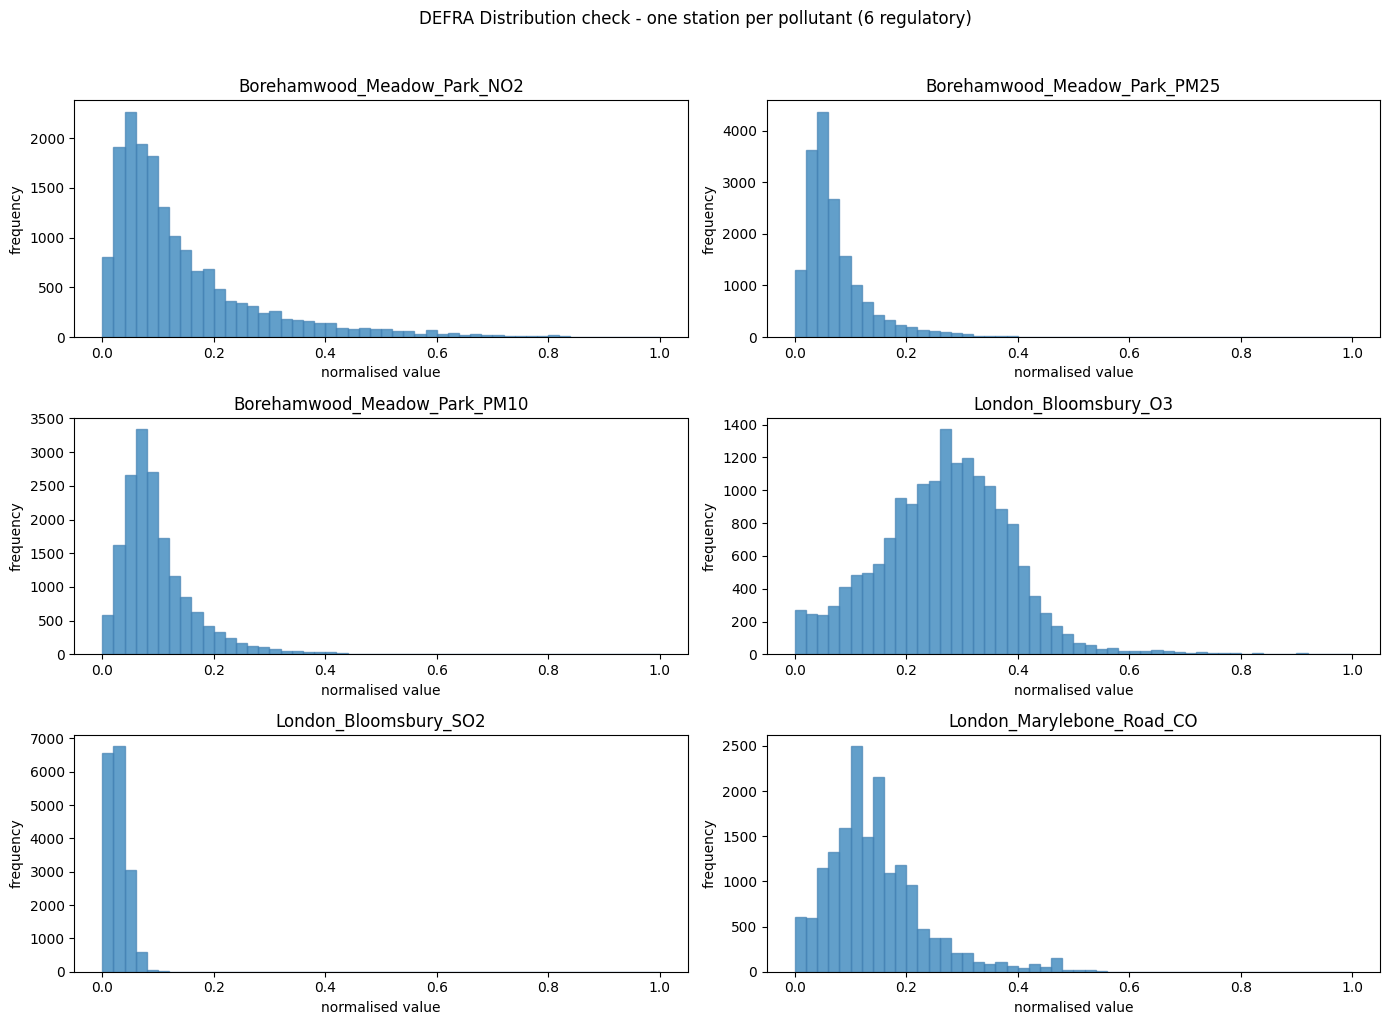

In [29]:
# Quick sanity check - one example per pollutant
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
axes = axes.flatten()

pollutants = ['NO2', 'PM25', 'PM10', 'O3', 'SO2', 'CO']

for i, poll in enumerate(pollutants):
    # Find first column for this pollutant
    poll_cols = [col for col in feature_names if f'_{poll}' in col]
    
    if poll_cols:
        col_name = poll_cols[0]
        col_idx = feature_names.index(col_name)
        
        # Plot distribution from training data
        axes[i].hist(X_train[:, -1, col_idx], bins=50, edgecolor='steelblue', alpha=0.7)
        axes[i].set_title(f'{col_name}')
        axes[i].set_xlabel('normalised value')
        axes[i].set_ylabel('frequency')
    else:
        axes[i].text(0.5, 0.5, f'No {poll} data', ha='center', va='center')
        axes[i].set_title(f'{poll} - not available')

plt.suptitle('DEFRA Distribution check - one station per pollutant (6 regulatory)', y=1.02)
plt.tight_layout()
plt.savefig(visualisation_path / 'defra_6pollutant_distributions.png', dpi=150)
plt.show()

### Complete!

**Summary:**

- Loaded DEFRA data from optimised folder
- Filtered to 6 regulatory pollutants (matching LAQN)
- Applied same tiered missing value handling as LAQN
- Created sequences for CNN (3D) and RF (2D)
- Saved all arrays and metadata

**Next steps:**
1. Load this ml_prep_all folder in training notebooks
2. Compare RF and CNN performance between DEFRA and LAQN
3. Analyse if data quality differences affect predictions